# Workers productivity

Contenido:
- Analisis de datos de la productividad de trabajadores.
- Modelo predictivo de la productividad de los trabajadores.

Importamos librerias necesarias

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")


from sklearn.metrics import accuracy_score, confusion_matrix,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder,PolynomialFeatures
from sklearn.linear_model import LinearRegression

Leemos nuestros datos

In [19]:
df = pd.read_csv('garments_worker_productivity.csv')

Atributos del dataset:
1. **date**: Date in MM-DD-YYYY
3. **quarter**: A portion of the month. A month was divided into four quarters
4. **department**: Associated department with the instance
2. **day**: Day of the Week
5. **team**: Associated team number with the instance
8. **targeted_productivity**: Targeted productivity set by the Authority for each team for each day.
9. **smv**: Standard Minute Value, it is the allocated time for a task 
10. **wip**: Work in progress. Includes the number of unfinished items for products 
11. **over_time**: Represents the amount of overtime by each team in minutes
12. **incentive**: Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.
13. **idle_time**: The amount of time when the production was interrupted due to several reasons 
14. **idle_men**: The number of workers who were idle due to production interruption
7. **no_of_style_change**: Number of changes in the style of a particular product
6. **no_of_workers**: Number of workers in each team 
15. **actual_productivity**: The actual % of productivity that was delivered by the workers. It ranges from 0-1.

Veamos los tipos de departamentos

In [20]:
df['department'].value_counts()

sweing        691
finishing     257
finishing     249
Name: department, dtype: int64

Aquí podemos ver que un espacio divide en dos categorías diferentes a "finishing". Ahora vamos a fusionarlas.

In [21]:
df['department'] = df['department'].apply(lambda x: 'finishing' if x.replace(" ","") == 'finishing' else 'sewing' )

Podemos ver que ahora ya tenemos los departamentos correctos

<AxesSubplot:ylabel='department'>

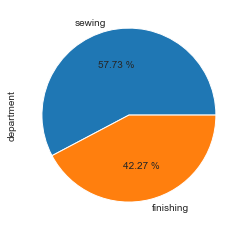

In [22]:
df.department.value_counts().plot.pie(autopct='%.2f %%')

### Conociendo mas el dataset

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [24]:
df.isnull().sum()

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

Podemos ver que hay 506 nulos en la columna de "wip"

In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
team,1197.0,6.426901,3.463963,1.000000,3.000000,6.000000,9.000000,12.000000
targeted_productivity,1197.0,0.729632,0.097891,0.070000,0.700000,0.750000,0.800000,0.800000
smv,1197.0,15.062172,10.943219,2.900000,3.940000,15.260000,24.260000,54.560000
wip,691.0,1190.465991,1837.455001,7.000000,774.500000,1039.000000,1252.500000,23122.000000
over_time,1197.0,4567.460317,3348.823563,0.000000,1440.000000,3960.000000,6960.000000,25920.000000
incentive,1197.0,38.210526,160.182643,0.000000,0.000000,0.000000,50.000000,3600.000000
idle_time,1197.0,0.730159,12.709757,0.000000,0.000000,0.000000,0.000000,300.000000
idle_men,1197.0,0.369256,3.268987,0.000000,0.000000,0.000000,0.000000,45.000000
no_of_style_change,1197.0,0.150376,0.427848,0.000000,0.000000,0.000000,0.000000,2.000000
no_of_workers,1197.0,34.609858,22.197687,2.000000,9.000000,34.000000,57.000000,89.000000


### Saquemos algunas graficas

Comparemos la productividad real y la productividad objetivo para ver el rendimiento de los empleados.

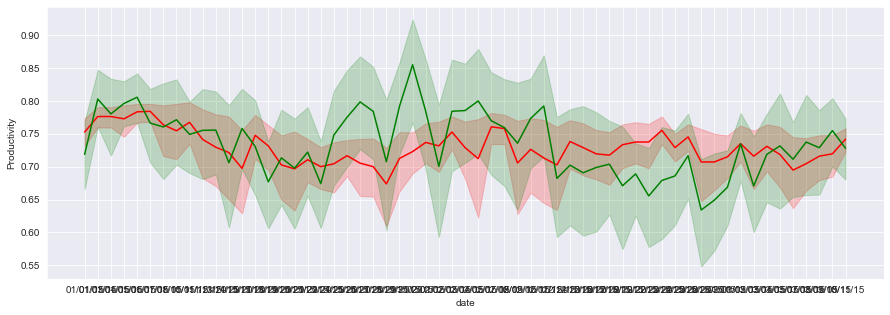

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (15,5))
ax=sns.lineplot(y='targeted_productivity',x='date' ,color = "red", data =df,legend='brief')
ax=sns.lineplot(y= 'actual_productivity',x='date',data=df, color="green", legend = 'brief')
ax.set(ylabel = 'Productivity')
plt.show()

Ahora analicemos si el día concreto de la semana o el equipo o el departamento tiene algún efecto significativo en la productividad.

Productividad en Thursday :  0.7226408815326634
Productividad en Saturday :  0.7519288593743317
Productividad en Sunday :  0.7286041288078817
Productividad en Monday :  0.7354884994170855
Productividad en Tuesday :  0.742700917676617
Productividad en Wednesday :  0.7304619085144229


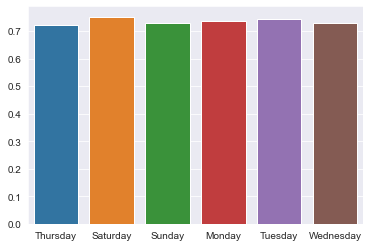

In [35]:
l = []
l1=[]
column_name = "day"
for i in list(df[column_name].unique()):
    print( f"Productividad en {i} : ",df[df[column_name] == i]["actual_productivity"].mean())
    l.append(df[df[column_name] == i]["actual_productivity"].mean())
    l1.append(i)
    dictionary = {"data":l,"keys":l1}
    sns.barplot( x = "keys" , y = "data", data = dictionary)
plt.savefig('days.png')

Como podemos ver arriba, la productividad no depende del equipo, la categoría, el trimestre o el día.

Vamos a trazar la matriz de correlación para ver la cantidad de correlación -

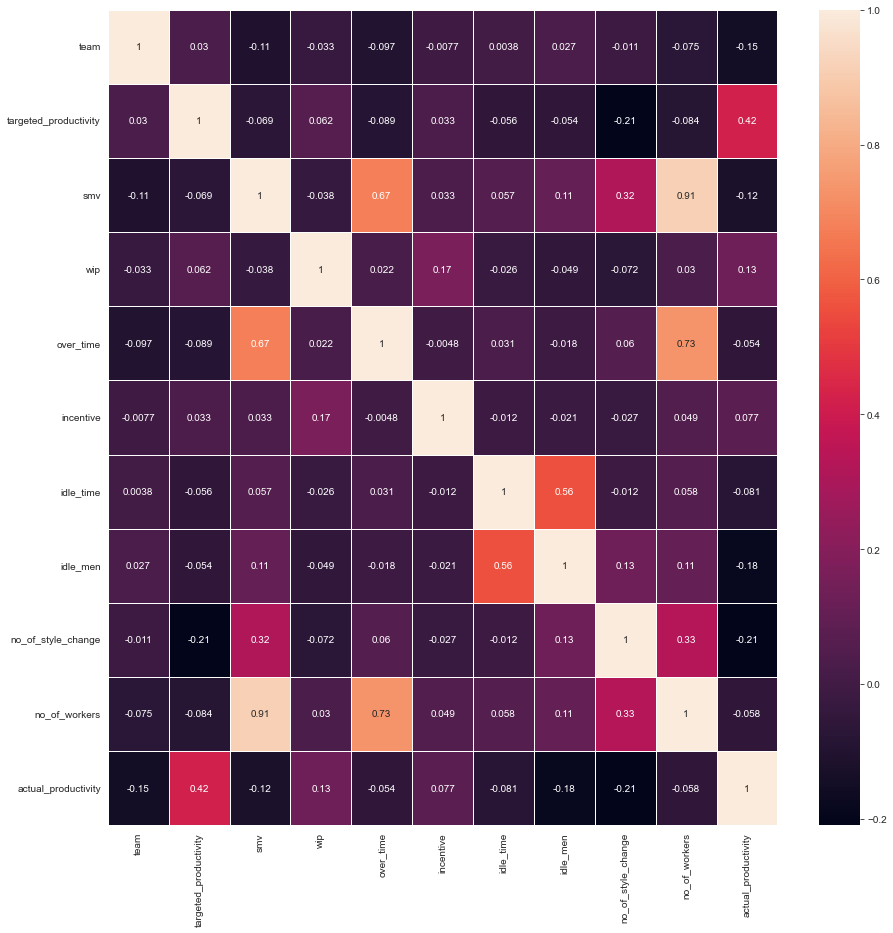

In [42]:
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(15,15)) # Sample figsize in inches
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)
plt.show()

So from these data, it is quite evident productivity mainly depends on the target productivity as having a target will motivate and boost the employees.

## Let’s Prepare the final data and start the prediction.

#### Hagamos una limpieza y un preprocesamiento de los datos antes de pasar a la predicción

In [43]:
df['date'] = pd.to_datetime(df['date'])

In [44]:
df.date

0      2015-01-01
1      2015-01-01
2      2015-01-01
3      2015-01-01
4      2015-01-01
          ...    
1192   2015-03-11
1193   2015-03-11
1194   2015-03-11
1195   2015-03-11
1196   2015-03-11
Name: date, Length: 1197, dtype: datetime64[ns]

Así que los datos que tenemos son de 3 meses. 
Optamos por dejar el dia ya que como son pocos meses es suficiente en lugar de la fecha completa.

In [45]:
df['Dia']=df['date'].dt.day
df.drop(['date'],axis=1, inplace=True)

Optamos por llenar los wip faltantes por la media de la misma

In [46]:
df['wip'].fillna(int(df['wip'].mean()), inplace=True)

In [47]:
df.isnull().sum()

quarter                  0
department               0
day                      0
team                     0
targeted_productivity    0
smv                      0
wip                      0
over_time                0
incentive                0
idle_time                0
idle_men                 0
no_of_style_change       0
no_of_workers            0
actual_productivity      0
Dia                      0
dtype: int64

Ahora podemos ver que no tenemos datos faltantes

### Encode

En los datos, puedes ver algunas columnas no numéricas. Así que vamos a codificarlas, ya que la mayoría de los algoritmos de aprendizaje automático sólo funcionan con datos numéricos.

Let’s encode the data with MultiColumnLabelEncoder —

In [48]:
# !pip install MultiColumnLabelEncoder

In [49]:
import MultiColumnLabelEncoder
Mcle = MultiColumnLabelEncoder.MultiColumnLabelEncoder()
df = Mcle.fit_transform(df)

In [50]:
x=df.drop(['actual_productivity'],axis=1)
y=df['actual_productivity']

### Predicting the Productivity

Vamos a predecir la productividad utilizando algoritmos de regresión en Python. Antes de eso, vamos a preparar los datos de entrenamiento y de prueba -

In [53]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y,train_size=0.8,random_state=0)

### Using LinearRegression

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
model_lr=LinearRegression()
model_lr.fit(x_train,y_train)
pred_test=model_lr.predict(x_test)
print("test_MSE:",mean_squared_error(y_test, pred_test))
print("test_MAE:",mean_absolute_error(y_test, pred_test))
print("R2_score:{}".format(r2_score(y_test, pred_test)))

test_MSE: 0.020550898379008156
test_MAE: 0.1039331688716904
R2_score:0.30491098975810416


### Using Random Forest Regressor

In [43]:
from sklearn.ensemble import RandomForestRegressor
model_rfe = RandomForestRegressor(n_estimators=200,max_depth=5)
model_rfe.fit(x_train, y_train)
pred = model_rfe.predict(x_test)
print("test_MSE:",mean_squared_error(y_test, pred))
print("test_MAE:",mean_absolute_error(y_test, pred))
print("R2_score:{}".format(r2_score(y_test, pred)))

test_MSE: 0.015041658943594188
test_MAE: 0.08501485741172667
R2_score:0.4912489159997664


### Using XGBoost

In [44]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1)
model_xgb.fit(x_train, y_train)
pred3=model_xgb.predict(x_test)
print("test_MSE:",mean_squared_error(y_test, pred3))
print("test_MAE:",mean_absolute_error(y_test, pred3))
print("R2_score:{}".format(r2_score(y_test, pred3)))

ModuleNotFoundError: No module named 'xgboost'

**FALTA MODIFICAR** So we have achieved 0.07 — Mean Absolute Error and 0.01 Mean Square error which says our model is performing very well.

So Out of all algorithms, XGBoost has performed well. In this way, we can predict the productivity of employees.

In [45]:
from sklearn.svm import SVR

model_svr = SVR(kernel='rbf', C=10, epsilon=0.00001) # set kernel and hyperparameters
svr = model_svr.fit(x_train, y_train)
pred4 = model_svr.predict(x_test)
print("test_MSE:",mean_squared_error(y_test, pred4))
print("test_MAE:",mean_absolute_error(y_test, pred4))
print("R2_score:{}".format(r2_score(y_test, pred4)))

test_MSE: 0.026459445509063772
test_MAE: 0.11576166517249108
R2_score:0.10506735757932617


In [46]:
from sklearn.linear_model import Lasso

las_reg = Lasso()
las_reg.fit(x_train, y_train)
#Prediction using test set 
pred5 = las_reg.predict(x_test)
print("test_MSE:",mean_squared_error(y_test, pred5))
print("test_MAE:",mean_absolute_error(y_test, pred5))
print("R2_score:{}".format(r2_score(y_test, pred5)))

test_MSE: 0.029032698375057873
test_MAE: 0.12988811271294887
R2_score:0.01803272995677041


In [47]:
from sklearn.linear_model import Ridge

rid_reg = Ridge()
rid_reg.fit(x_train, y_train)
#Prediction using test set 
pred6 = rid_reg.predict(x_test)
print("test_MSE:",mean_squared_error(y_test, pred6))
print("test_MAE:",mean_absolute_error(y_test, pred6))
print("R2_score:{}".format(r2_score(y_test, pred6)))

test_MSE: 0.020697487907402185
test_MAE: 0.10519098125399157
R2_score:0.2999529208540551


In [60]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error

dt_regressor = DecisionTreeRegressor(random_state = 0)
dt_regressor.fit(x_train,y_train)
#Predicting using test set 
pred7 = dt_regressor.predict(x_test)
print("test_MSE:",mean_squared_error(y_test, pred7))
print("test_neg_mean_squared_log_error:",mean_squared_log_error(y_test, pred7))

print("test_MAE:",mean_absolute_error(y_test, pred7))
print("R2_score:{}".format(r2_score(y_test, pred7)))

test_MSE: 0.02996963200048947
test_neg_mean_squared_log_error: 0.011371695731650564
test_MAE: 0.10155298398750001
R2_score:-0.013656992524112788
